In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint



In [14]:
DATA_DIR = "car_dataset"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
TOTAL_EPOCHS = 10



In [15]:
MODEL_PATH = "model/car_model_identifier.h5"
HISTORY_PATH = "model/training_history.pkl"


In [16]:
# Data Augmentation
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = train_val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = train_val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'valid'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)



Found 3500 images belonging to 10 classes.
Found 749 images belonging to 10 classes.


In [17]:
if os.path.exists(MODEL_PATH) and os.path.exists(HISTORY_PATH):
    print("📂 Loading existing model and history...")
    model = load_model(MODEL_PATH)
    with open(HISTORY_PATH, "rb") as f:
        history_dict = pickle.load(f)
    initial_epoch = len(history_dict['accuracy'])
    print(f"Resuming training from epoch {initial_epoch}/{TOTAL_EPOCHS}")
else:
    print("🚀 Creating new model...")
    base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(train_gen.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_dict = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    initial_epoch = 0



📂 Loading existing model and history...


Resuming training from epoch 10/10


In [18]:
# TRAIN (RESUME IF NEEDED)
if initial_epoch < TOTAL_EPOCHS:
    checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=False)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=TOTAL_EPOCHS,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint]
    )

    # Append new results to history
    for key in history.history:
        history_dict[key].extend(history.history[key])

    # Save updated history
    os.makedirs("model", exist_ok=True)
    with open(HISTORY_PATH, "wb") as f:
        pickle.dump(history_dict, f)

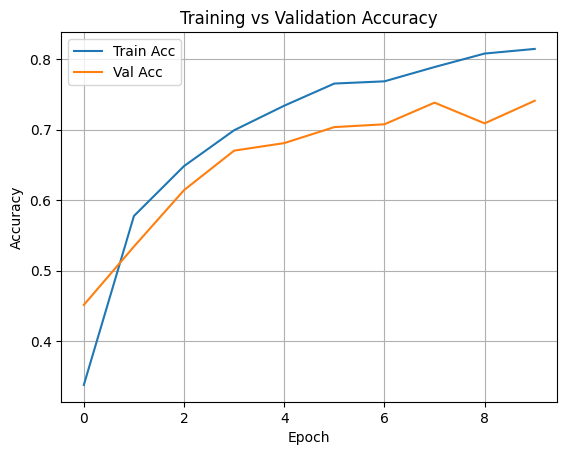

In [19]:
# Accuracy Plot
plt.plot(history_dict['accuracy'], label='Train Acc')
plt.plot(history_dict['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.grid()
plt.show()



In [20]:
# Final save after training completes
os.makedirs("model", exist_ok=True)
model.save(MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")



✅ Model saved to model/car_model_identifier.h5


In [21]:
# Evaluate on Test Set
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_gen)
print(f"📊 Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")



Found 750 images belonging to 10 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 837ms/step - accuracy: 0.6969 - loss: 0.8601
📊 Test Accuracy: 67.33% | Test Loss: 0.9575


In [27]:
# PREDICTION FUNCTION
def predict_car(img_path):
    loaded_model = load_model(MODEL_PATH)

    # Load class labels
    datagen_eval = ImageDataGenerator(rescale=1./255)
    tmp = datagen_eval.flow_from_directory(
        os.path.join(DATA_DIR, 'train'),
        target_size=(224, 224))
    class_names = list(tmp.class_indices.keys())

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = loaded_model.predict(img_array)[0]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100


    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%) ")
    plt.show()


Found 3500 images belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


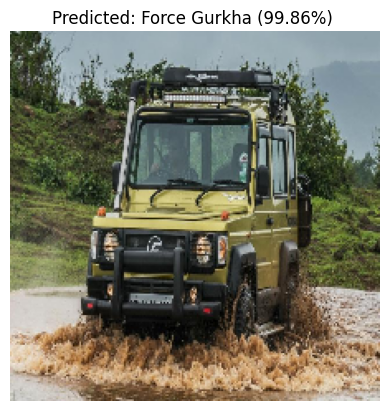

In [32]:
# Run prediction
predict_car("predict/test4.jpg")  
